# Ubrzavanje Pythona

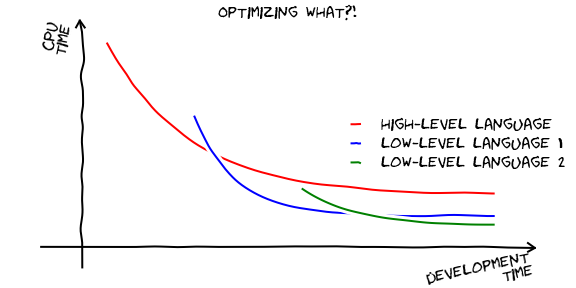

In [1]:
from IPython.display import Image
Image("https://raw.github.com/jrjohansson/scientific-python-lectures/master/images/optimizing-what.png")

Katkada korištenje Numpy-a ne daje dovoljno ubrzanje, ili je teško/nespretno vektorizirati kod. Tada postoji više opcija

1. spori dio koda (koji dio koda je spor možemo saznati profiliranjem koda, npr. pomoću IPythonove magične funkcije `%prun`) možemo napisati npr. u C-u. U Pythonu je taj proces prilično bezbolan.
2. spori dio koda možemo implementirati u [Cythonu](http://cython.org/), koji je proširenje Pythona
3. možemo ubrzati kod korištenjem specijaliziranih kompajlera koji optimiziraju strojni kod

Pod 3., postoji cijeli niz kompajlera za Python: [PyPy](http://pypy.org/), [Nuitka](http://nuitka.net/), [shedskin](https://code.google.com/p/shedskin/), [parakeet](https://github.com/iskandr/parakeet), [psyco](http://psyco.sourceforge.net/), [Theano](http://deeplearning.net/software/theano/) i [Numba](http://numba.pydata.org/). 

Mi ćemo se ovdje pozabaviti s Cythonom i Numbom. U oba slučaja je od najveće važnosti precizirati vrste podataka (tzv. anotacija) jer se onda strojni kod može dobro optimizirati.

## Cython

In [2]:
# olakšava rad u Cythonu u IPythonu
%load_ext Cython

In [3]:
a=10
b=20

`%%cython_inline` magična funkcija koristi `Cython.inline` da bi se kompajlirao Cython izraz. `return` služi za slanje izlaza.

In [4]:
%%cython_inline
return a+b

Compiling /projects/95cb524c-f1ac-4a19-908e-5f47c10f47c1/.cython/inline/_cython_inline_6941fceee5936d163c6c3563c2edbe1e.pyx because it changed.
[1/1] Cythonizing /projects/95cb524c-f1ac-4a19-908e-5f47c10f47c1/.cython/inline/_cython_inline_6941fceee5936d163c6c3563c2edbe1e.pyx


30

`%%cython_pyximport` magična funkcija služi da se unese proizvoljan Cython kod u IPython notebook ćeliju. Taj kod se sprema u `.pyx` u radnom direktoriju i onda importira koristeći `pyximport`. Moramo specificirati ime modula (u donjem slučaju `foo`). Svi objekti modula se automatski importiraju.

In [5]:
%%cython_pyximport foo
def f(x):
    return 4.0*x

In [6]:
f(10)

40.0

U dosadašnjim primjerima Cython kod se nije razlikovao od Python koda. U sljedećem primjeru ćemo vidjeti neka od proširenja Pythona koja nudi Cython.

Magična funkcija `%%cython` je slična funkciji `%%cython_pyximport`, ali ne traži ime modula te sve datoteke sprema u privremeni direktorij.

Jedan od načina računanja broja $\pi$ je korištenjem formule
$$ \frac{\pi}{4} = \int_0^1 \sqrt{1-x^2}\,\mathrm{d}x.$$  
A integral možemo aproksimirati pomoću trapezne formule, što nam daje
$$\frac{\pi}{4}\approx \frac{1}{n}\left(\frac{1}{2}+\sum_{i=1}^n\sqrt{1-\left(\frac{i}{n}\right)^2} \right) $$
Krenimo od običnog Pythona. 

In [7]:
from math import sqrt
def funkcija(x):
    return sqrt(1-x**2)

def integral4pi(n):
    korak = 1.0/n
    rez = (funkcija(0)+funkcija(1))/2
    for i in range(n):
        rez += funkcija(i*korak)
    return 4*rez*korak

In [8]:
approx=integral4pi(10**7)
print ('pi={}'.format(approx))

pi=3.1415930535527115


In [9]:
%timeit integral4pi(10**7)

1 loop, best of 3: 4.17 s per loop


### Cython verzija
Ovdje je

- `cimport`: ekvivalent importa, ali možemo učitavati i iz C ili C++ biblioteka
- `cdef`: ekvivalent za def, gdje definiramo (kao u C-u) tipove podataka; također služi za deklariranje tipa varijabli

In [10]:
%%cython

cimport cython
from libc.math cimport sqrt
cdef double cy_funkcija(double x):
    return sqrt(1-x**2)

def cy_integral4pi(int n):
    cdef double korak, rez
    cdef int i
    korak = 1.0/n
    rez = (cy_funkcija(0)+cy_funkcija(1))/2
    for i in range(n):
        rez += cy_funkcija(i*korak)
    return 4*rez*korak

In [11]:
cy_approx = cy_integral4pi(10**7)
print ('pi={}'.format(cy_approx))

pi=3.1415930535527115


In [12]:
%timeit cy_integral4pi(10**7)

10 loops, best of 3: 72 ms per loop


### Složeniji primjer
Ovdje je

- `@`: Pythonova sintaksa za tzv. [dekoratore](http://en.wikipedia.org/wiki/Python_syntax_and_semantics#Decorators)
- `nogil`: GIL je skraćenica od _global interpreter lock_, koji spriječava simultano izvršavanje koda u više niti (eng. threads), ovdje s `nogil` deklariramo da je sigurno pozvati funkciju bez GIL-a
- `with nogil`: odgovarajući dio koda ne koristi GIL

In [13]:
%%cython
cimport cython
from libc.math cimport exp, sqrt, pow, log, erf
@cython.cdivision(True)
cdef double std_norm_cdf(double x) nogil:
    return 0.5*(1+erf(x/sqrt(2.0)))
@cython.cdivision(True)
def black_scholes(double s, double k, double t, double v, double rf, double div, double cp):
    """s : početna cijena dionice
    k : fiksirana cijena (strike price)
    t : vrijeme 
    v : volatilnost
    rf : bezrizična kamata
    div : dividenda
    cp : put/call paritet
    """
    cdef double d1, d2, optprice
    with nogil:
        d1 = (log(s/k)+(rf-div+0.5*pow(v,2))*t)/(v*sqrt(t))
        d2 = d1 - v*sqrt(t)
        optprice = cp*s*exp(-div*t)*std_norm_cdf(cp*d1) - cp*k*exp(-rf*t)*std_norm_cdf(cp*d2)
    return optprice

In [14]:
black_scholes(100.0, 100.0, 1.0, 0.3, 0.03, 0.0, -1)

10.327861752731728

In [15]:
%timeit black_scholes(100.0, 100.0, 1.0, 0.3, 0.03, 0.0, -1)

The slowest run took 53.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 328 ns per loop


Cython omogućava linkanje dodatnih biblioteka pri kompajliranju, u ovom slučaju standardne matematičke biblioteke

In [33]:
%%cython -lm
from libc.math cimport sin
print ('sin(1)=', sin(1))

sin(1)= 0.8414709848078965


### Još jedan primjer, gdje koristimo numpy nizove

Računamo kumulativnu sumu niza

In [34]:
import numpy as np
def py_dcumsum(a):
    b = np.empty_like(a)
    b[0] = a[0]
    for n in range(1,len(a)):
        b[n] = b[n-1]+a[n]
    return b

In [35]:
a = np.random.rand(100000)
b = np.empty_like(a)

In [36]:
%%cython

cimport numpy

def cy_dcumsum2(numpy.ndarray[numpy.float64_t, ndim=1] a, numpy.ndarray[numpy.float64_t, ndim=1] b):
    cdef int i, n = len(a)
    b[0] = a[0]
    for i from 1 <= i < n:
        b[i] = b[i-1] + a[i]
    return b

In [37]:
%timeit cy_dcumsum2(a,b)

1000 loops, best of 3: 328 µs per loop


In [38]:
%timeit py_dcumsum(a)

10 loops, best of 3: 32.4 ms per loop


## Numba

Numba je just-in-time kompajler koji korisiti LLVM. Korištenje numbe je zapravo dosta jednostavno.

In [39]:
# iz numbe učitavamo jit kompajler
from numba import jit

from numpy import arange

Funkcija `sum2d(arr)`će biti optimizirana, a cijela procedura se svela na korištenje jednog dekoratora. 

In [40]:
# @jit je dekorator
@jit
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [41]:
def py_sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [42]:
a = arange(9).reshape(3,3)

In [43]:
%timeit sum2d(a)

The slowest run took 214864.54 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 344 ns per loop


In [44]:
%timeit py_sum2d(a)

The slowest run took 10.92 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 5.66 µs per loop


### Kompliciraniji primjer

In [45]:
import numpy
def filter2d(image, filt):
    M, N = image.shape
    Mf, Nf = filt.shape
    Mf2 = Mf // 2
    Nf2 = Nf // 2
    result = numpy.zeros_like(image)
    for i in range(Mf2, M - Mf2):
        for j in range(Nf2, N - Nf2):
            num = 0.0
            for ii in range(Mf):
                for jj in range(Nf):
                    num += (filt[Mf-1-ii, Nf-1-jj] * image[i-Mf2+ii, j-Nf2+jj])
            result[i, j] = num
    return result
from numba import double
fastfilter_2d = jit(double[:,:](double[:,:], double[:,:]))(filter2d)

In [46]:
image = numpy.random.random((100, 100))
filt = numpy.random.random((10, 10))

In [47]:
%timeit fastfilter_2d(image, filt)

1000 loops, best of 3: 1.7 ms per loop


In [48]:
%timeit filter2d(image, filt)

1 loop, best of 3: 499 ms per loop


### Paralelizacija
Drugi način ubrzavanja izvršavanja programa je pomoću paralelizacije. To je opsežna tema sama po sebi te u nju nećemo ulaziti.
Popularni način paralelizacije je npr. pomoću [Apache Sparka](https://spark.apache.org/) ili pomoću [Dask](http://dask.pydata.org/) biblioteke.

In [49]:
from verzije import *
from IPython.display import HTML
HTML(print_sysinfo()+info_packages('cython,numpy,numba'))